# Proyek Klasifikasi Gambar: A Dataset for Vegetable Identification
- **Nama:** Frisnadi
- **Email:** frisnadi1@gmail.com
- **ID Dicoding:** frisnadiyk

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.17.1


## Data Preparation

### Data Loading

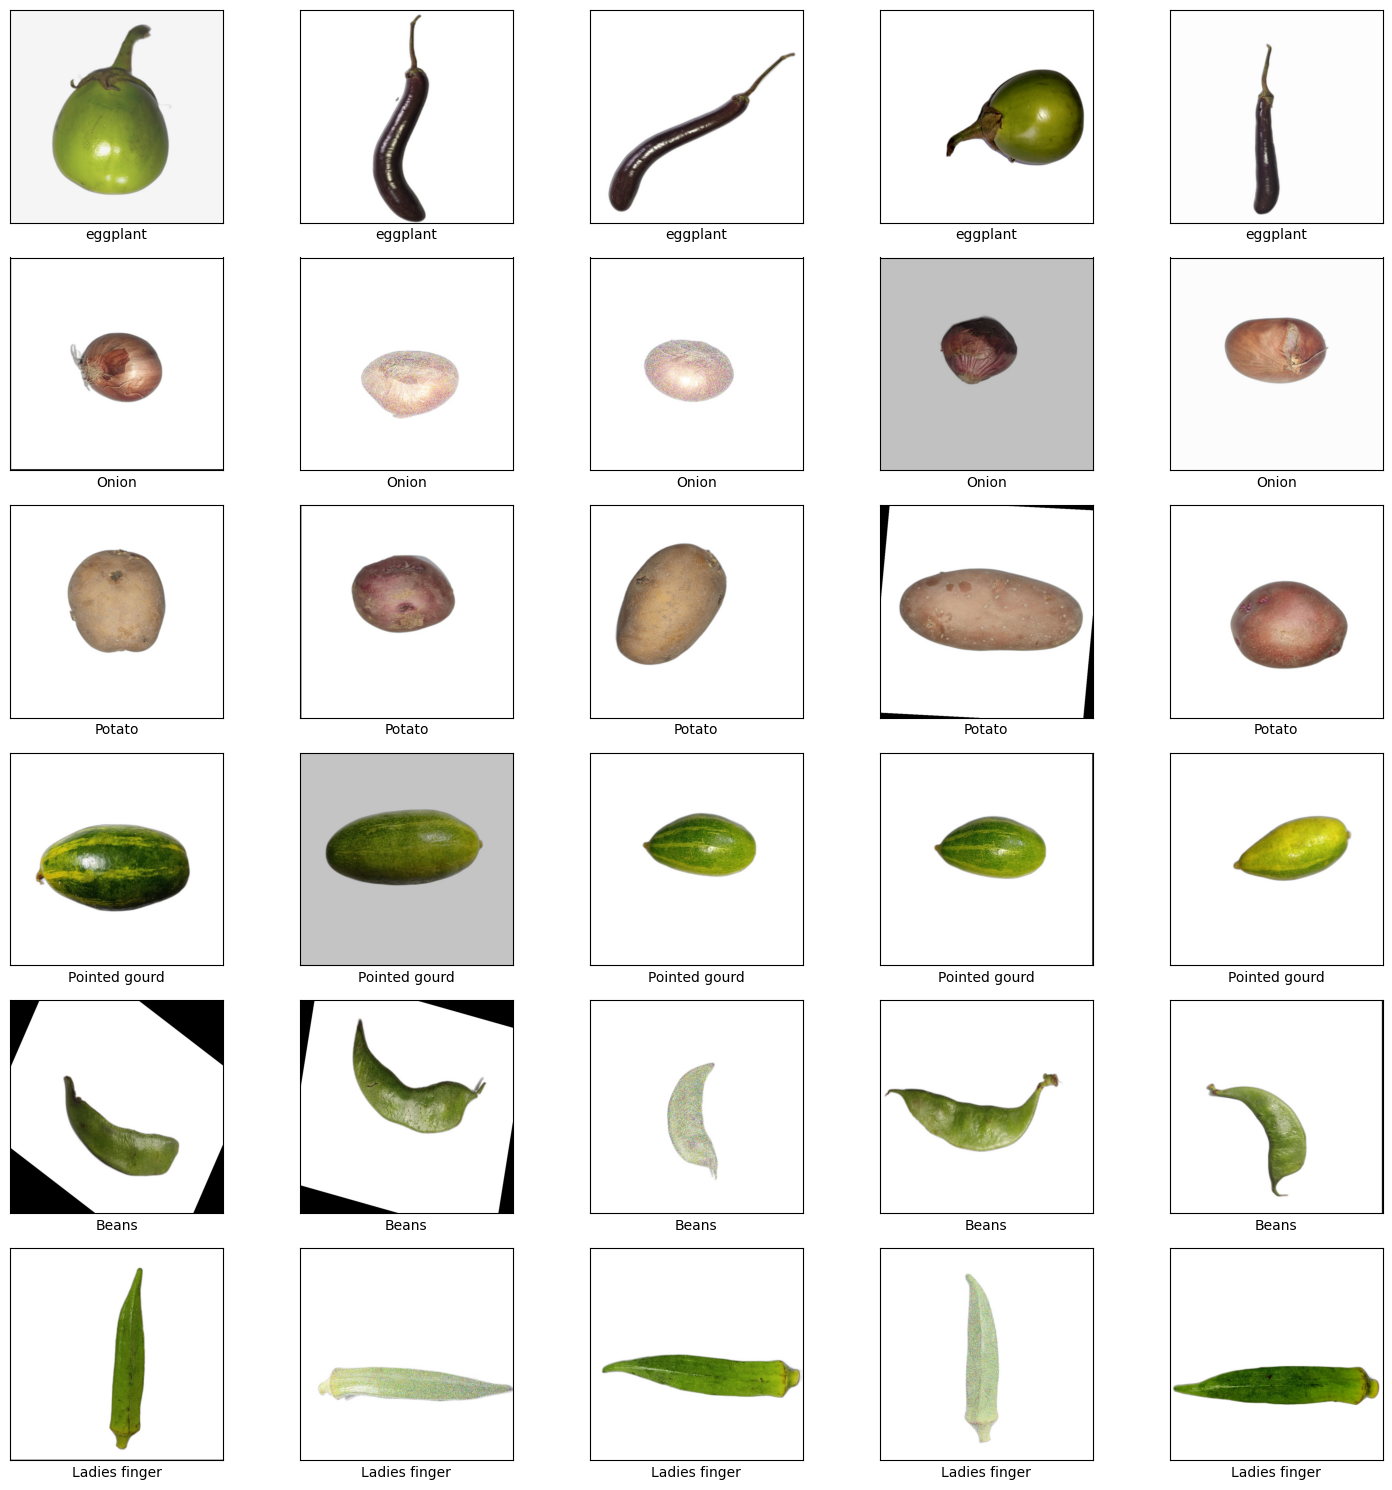

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Path awal dataset
dataset_path = "/kaggle/input/a-dataset-for-vegetable-identification/A Dataset for Vegetable Identification/Vegetable identification dataset/Vegetable identification dataset/Augmented dataset"

vegetable_images = {}

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_path): 
        clean_class_name = class_name.replace("Augmented ", "").strip()
        vegetable_images[clean_class_name] = [os.path.join(class_path, img) for img in os.listdir(class_path)]

fig, axs = plt.subplots(len(vegetable_images.keys()), 5, figsize=(15, 15))

for i, (class_name, image_paths) in enumerate(vegetable_images.items()):
    if len(image_paths) < 5: 
        selected_images = image_paths
    else:
        selected_images = np.random.choice(image_paths, 5, replace=False)

    for j, img_path in enumerate(selected_images):
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()


#### Plot Distribusi gambar semua Kelas

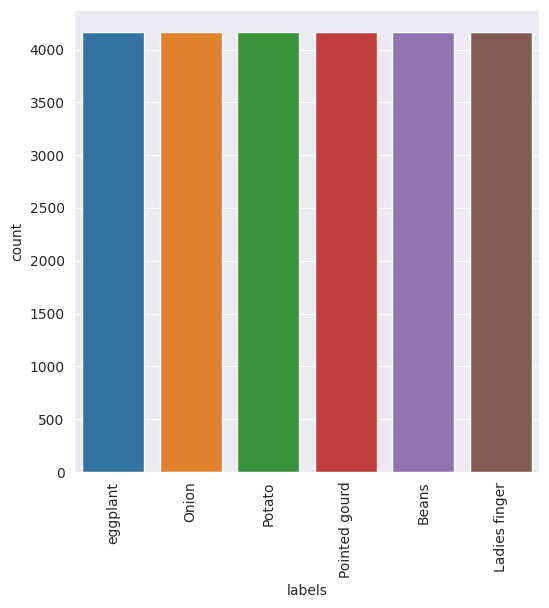

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path awal dataset
dataset_path = "/kaggle/input/a-dataset-for-vegetable-identification/A Dataset for Vegetable Identification/Vegetable identification dataset/Vegetable identification dataset/Augmented dataset"

# List untuk menyimpan informasi gambar
file_name = []
labels = []
full_path = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_path):
        # Hapus kata " augmented" dari nama kategori
        clean_class_name = class_name.replace("Augmented ", "")
        
        for img_name in os.listdir(class_path):
            file_name.append(img_name)
            labels.append(clean_class_name)
            full_path.append(os.path.join(class_path, img_name))

# Simpan ke dalam DataFrame
distribution_df = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

# Plot distribusi gambar per kelas
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.countplot(x="labels", data=distribution_df)
plt.xticks(rotation=90)
plt.show()


#### Check number of images and resolution size

### Data Preprocessing

#### Split Dataset

In [11]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Path dataset asli
dataset_path = "/kaggle/input/a-dataset-for-vegetable-identification/A Dataset for Vegetable Identification/Vegetable identification dataset/Vegetable identification dataset/Augmented dataset"

# Path dataset bersih
clean_dataset_path = "/kaggle/working/vegetables-dataset"
train_path = os.path.join(clean_dataset_path, "train")
test_path = os.path.join(clean_dataset_path, "test")

# Buat folder utama jika belum ada
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Split ratio
test_ratio = 0.2

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):
        clean_class_name = class_name.replace("Augmented ", "")
        train_class_path = os.path.join(train_path, clean_class_name)
        test_class_path = os.path.join(test_path, clean_class_name)

        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Ambil daftar semua gambar
        all_images = os.listdir(class_path)
        random.shuffle(all_images)

        # Split train dan test
        train_images, test_images = train_test_split(all_images, test_size=test_ratio, random_state=42)

        # Copy gambar ke train set
        for img_name in train_images:
            shutil.copy(os.path.join(class_path, img_name), os.path.join(train_class_path, img_name))

        # Copy gambar ke test set
        for img_name in test_images:
            shutil.copy(os.path.join(class_path, img_name), os.path.join(test_class_path, img_name))

# Cek jumlah gambar per kelas di train dan test
for split, split_path in [("Training", train_path), ("Test", test_path)]:
    print(f"\n=== {split} Set ===")
    for class_name in os.listdir(split_path):
        class_folder = os.path.join(split_path, class_name)
        print(f"Total {class_name} images: {len(os.listdir(class_folder))}")



=== Training Set ===
Total Pointed gourd images: 3332
Total Ladies finger images: 3332
Total Potato images: 3332
Total Onion images: 3332
Total Beans images: 3332
Total eggplant images: 3332

=== Test Set ===
Total Pointed gourd images: 834
Total Ladies finger images: 834
Total Potato images: 834
Total Onion images: 834
Total Beans images: 834
Total eggplant images: 834


In [12]:
datagen = ImageDataGenerator(rescale=1/255.)

# Generator untuk Training Set
train_generator = datagen.flow_from_directory(
    train_path,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Generator untuk Test Set
test_datagen = ImageDataGenerator(rescale=1/255.)
val_generator = test_datagen.flow_from_directory(
    test_path,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 19992 images belonging to 6 classes.
Found 5004 images belonging to 6 classes.


## Modelling

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Bersihkan sesi sebelumnya
tf.keras.backend.clear_session()

# Inisialisasi model
model_final = Sequential()

# 1st Convolutional layer
model_final.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))  # Ubah ke (150,150,1) jika grayscale
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer
model_final.add(Conv2D(64, (4, 4), padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer
model_final.add(Conv2D(128, (7, 7), padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))

# Flatten layer
model_final.add(Flatten())

# Fully connected layer
model_final.add(Dense(128, activation='relu'))
model_final.add(Dropout(0.5))
model_final.add(Dense(64, activation='relu'))
model_final.add(Dropout(0.3))

# Output layer untuk 6 kelas dengan softmax
model_final.add(Dense(6, activation='softmax'))

# Compile model
model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adam lebih stabil
                    loss='categorical_crossentropy',  # Karena klasifikasi multi-kelas
                    metrics=['accuracy'])

# Print summary
print(model_final.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,753,350 (21.95 MB)

 Trainable params: 5,752,902 (21.95 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [15]:
# Hitung class weights untuk mengatasi ketidakseimbangan data
classes = [cls for cls in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, cls))]
count_per_class = {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in classes}
total_images = sum(count_per_class.values())

class_weights = {
    i: (1 / max(1, count_per_class[cls])) * (total_images / len(classes))
    for i, cls in enumerate(classes)
}

print("Class Weights:", class_weights)

# Callback untuk menghentikan training jika akurasi tercapai
class StopAtAccuracy(Callback):
    def __init__(self, target_acc=0.98):
        super(StopAtAccuracy, self).__init__()
        self.target_acc = target_acc  # Target akurasi

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy", 0)  # Ambil training accuracy (default 0 jika None)
        val_acc = logs.get("val_accuracy", 0)  # Ambil validation accuracy

        if acc >= self.target_acc and val_acc >= self.target_acc:
            print(f"\n✅ Accuracy {acc:.2%} dan Val Accuracy {val_acc:.2%} tercapai! Training dihentikan.")
            self.model.stop_training = True  # Hentikan training


Class Weights: {0: 0.9999999999999999, 1: 0.9999999999999999, 2: 0.9999999999999999, 3: 0.9999999999999999, 4: 0.9999999999999999, 5: 0.9999999999999999}


In [16]:
stop_at_95 = StopAtAccuracy(target_acc=0.97)

history_final = model_final.fit(
    train_generator,
    epochs=50,
    batch_size=32,
    validation_data=val_generator,
    class_weight=class_weights,  
    callbacks=[stop_at_95],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 130ms/step - accuracy: 0.5366 - loss: 1.3000 - val_accuracy: 0.9143 - val_loss: 0.2994
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 125ms/step - accuracy: 0.8628 - loss: 0.4045 - val_accuracy: 0.9738 - val_loss: 0.0890
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 113ms/step - accuracy: 0.9388 - loss: 0.1948 - val_accuracy: 0.9762 - val_loss: 0.0675
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 113ms/step - accuracy: 0.9536 - loss: 0.1460 - val_accuracy: 0.9259 - val_loss: 0.2348
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 117ms/step - accuracy: 0.9670 - loss: 0.1136 - val_accuracy: 0.9752 - val_loss: 0.0920
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 114ms/step - accuracy: 0.9727 - loss: 0.1003 - val_accuracy: 0.6715 - val_loss: 4.5885
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 114ms/step - accuracy: 0.9753 - loss: 0.0786 - val_accuracy: 0.9111 - val_loss: 0.3963
Epoch 8/50
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9823 - loss: 0.0698
✅ Accur

## Evaluasi dan Visualisasi

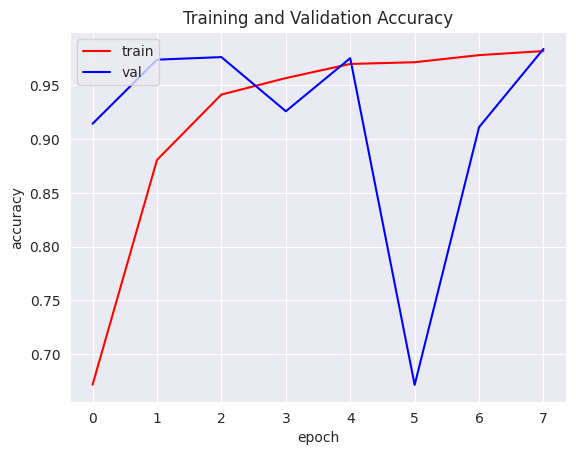

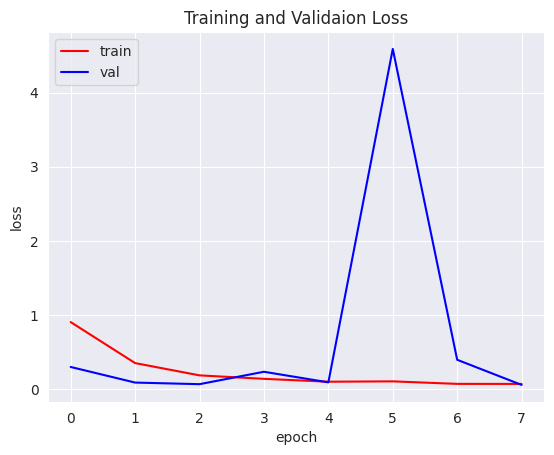

In [17]:
acc = history_final.history['accuracy']
val_acc = history_final.history['val_accuracy']
loss = history_final.history['loss']
val_loss = history_final.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

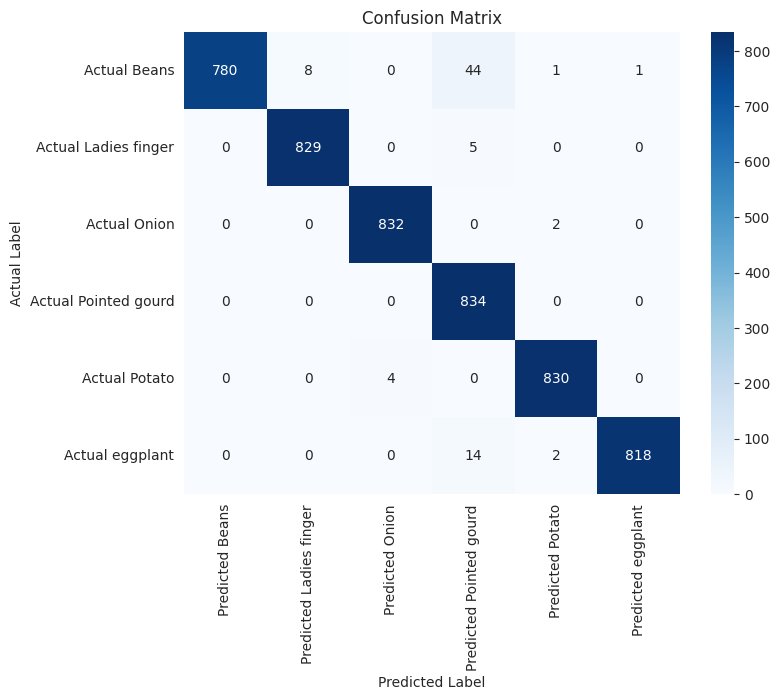


Classification Report:
               precision    recall  f1-score   support

        Beans     1.0000    0.9353    0.9665       834
Ladies finger     0.9904    0.9940    0.9922       834
        Onion     0.9952    0.9976    0.9964       834
Pointed gourd     0.9298    1.0000    0.9636       834
       Potato     0.9940    0.9952    0.9946       834
     eggplant     0.9988    0.9808    0.9897       834

     accuracy                         0.9838      5004
    macro avg     0.9847    0.9838    0.9838      5004
 weighted avg     0.9847    0.9838    0.9838      5004



In [22]:
# Reset test generator
val_generator.reset()

# Prediksi model
preds_final = model_final.predict(val_generator, verbose=0)

# Konversi probabilitas ke kelas dengan argmax (untuk multi-class classification)
preds_final = np.argmax(preds_final, axis=1)

# Ambil label asli dari test_generator
y_true = val_generator.classes

# Nama kelas (sesuai urutan dalam generator)
class_labels = list(val_generator.class_indices.keys())

# Print Confusion Matrix
cm = confusion_matrix(y_true, preds_final)
cm_df = pd.DataFrame(cm, index=[f"Actual {cls}" for cls in class_labels], 
                          columns=[f"Predicted {cls}" for cls in class_labels])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true, preds_final, target_names=class_labels, digits=4))


## Konversi Model

In [19]:
model_final.export('/kaggle/working/submission/saved_model')

Saved artifact at '/kaggle/working/submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136969142591632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969142598848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969142833344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969142843024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969142838624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969142837920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969186487888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969186487360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969186484896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136969186488592: TensorSpec(shape=(), dtype=tf.resource, name=

In [20]:
model_final.save("model.h5")


In [21]:
# Install tensorflowjs
!pip -q install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.9 MB/s eta 0:00:000:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
plotnine 0.14.4 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.
pylibcudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which i

In [ ]:
# Konversi Model SavedModel ke TFJS
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /kaggle/working/submission/saved_model \
    /kaggle/working/submission/model_tfjs

In [ ]:
# Convert Model SavedModel to TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model('/kaggle/working/submission/saved_model')
tflite_model = converter.convert()
 
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
labels = [ "Beans", "Ladies finger", "Onion", "Pointed gourd", "Potato", "eggplant"]

# Simpan label ke file label.txt
with open('label.txt', 'w') as f:
  for label in labels:
    f.write(label + '\n')

!mkdir tflite
!mv model.tflite label.txt tflite/
!mv tflite submission/

In [ ]:
!pip -q freeze > requirements.txt

In [ ]:
!zip -r model.zip submission model.h5 requirements.txt

## Inference (Optional)

In [ ]:
class_indices = train_generator.class_indices
print(class_indices)

In [1]:
!pip -q install tensorflow

In [2]:
import tensorflow as tf
import requests

def images_preprocessing(filenames):
    image_tensors = []
    for filename in filenames:
        image = tf.io.decode_image(open(filename, 'rb').read(), channels=3)
        image = tf.image.resize(image, [150, 150])
        image = image / 255.0
        image_tensors.append(image)

    # Convert the list of images into a batch
    image_tensors = tf.stack(image_tensors)
    image_tensors = image_tensors.numpy().tolist()  # Convert to list format for JSON
    return image_tensors

# List of filenames for the images (Cat, Dog, Wild)
filenames = ['images/Beans.png', 'images/eggplant.png', 'images/ladies.png', 'images/pota.png', 'images/poited.png']

# Prepare the data (image batch) to be sent in the POST request
image_tensors = images_preprocessing(filenames=filenames)

json_data = {
    "instances": image_tensors
}

# Define the endpoint with format: http://localhost:8501/v1/models/MODEL_NAME:predict
endpoint = "http://localhost:8501/v1/models/rps_model:predict"
response = requests.post(endpoint, json=json_data)

# Process the response
response_json = response.json()
if 'predictions' in response_json:
    map_labels = {0: 'Beans', 1 : 'Ladies finger' , 2: 'Onion', 3: 'Pointed gourd', 4: 'Potato', 5: 'eggplant'}


    # Iterate through each prediction and print the result
    for i, prediction in enumerate(response_json['predictions']):
        predicted_label = tf.argmax(prediction).numpy()  # Get the predicted class
        print(f"Prediction for image {filenames[i]}: {map_labels[predicted_label]}")
else:
    print("Error: 'predictions' key not found in the response.")
    print("Response content:", response_json)

Prediction for image images/Beans.png: Beans
Prediction for image images/eggplant.png: eggplant
Prediction for image images/ladies.png: Ladies finger
Prediction for image images/pota.png: Potato
Prediction for image images/poited.png: Pointed gourd
